!pip install -U segmentation-models-pytorch albumentations --user

In [1]:
!pip install -U segmentation-models-pytorch albumentations --user

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt

In [3]:
x_train_dir = 'data_small_floodnet/train/train-org-img/'
y_train_dir = 'data_small_floodnet/train/train-label-img/'

x_valid_dir = 'data_small_floodnet/val/val-org-img/'
y_valid_dir = 'data_small_floodnet/val/val-label-img/'

x_test_dir = 'data_small_floodnet/test/test-org-img/'
y_test_dir = 'data_small_floodnet/test/test-label-img/'

In [4]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [5]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [6]:
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['background', 'building flooded', 'building non-flooded', 'road flooded', 'road non-flooded', 
               'water', 'tree', 'vehicle', 'pool', 'grass']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids1 = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids1]

        self.ids2 = os.listdir(masks_dir)
        self.masks_fps = [os.path.join(masks_dir, mask_id) for mask_id in self.ids2]

        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], cv2.COLOR_BGR2RGB)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids1)

In [7]:
import albumentations as albu

In [8]:
def get_training_augmentation():
    train_transform = [

#         albu.HorizontalFlip(p=0.5),
#         albu.ShiftScaleRotate(scale_limit=0.2, rotate_limit=20, shift_limit=0.2, p=0.8, border_mode=0),
#         albu.PadIfNeeded(min_height=480, min_width=480, always_apply=True, border_mode=0),
        albu.RandomCrop(height=512, width=512, always_apply=True),
#         albu.IAAAdditiveGaussianNoise(p=0.1),
#         albu.IAAPerspective(p=0.5),
#         albu.OneOf(
#             [
#                 albu.CLAHE(p=1),
#                 albu.RandomBrightness(p=1),
#                 albu.RandomGamma(p=1),
#             ],
#             p=0.9,
#         )
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(min_height=512, min_width=512, always_apply=True, border_mode=0),
        albu.RandomCrop(height=512, width=512, always_apply=True),
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

In [9]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [10]:
ENCODER = 'efficientnet-b6' #timm-mobilenetv3_small_075, efficientnet-b6, 
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['background', 'building flooded', 'building non-flooded', 'road flooded', 'road non-flooded', 
            'water', 'tree', 'vehicle', 'pool', 'grass']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
).to(DEVICE)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [11]:
!pip install -U albumentations[imgaug]
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)


train_loader = DataLoader(train_dataset, batch_size=2, shuffle=False, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=2, shuffle=False, num_workers=0)


In [12]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
    smp.utils.metrics.IoU(threshold=0.5, ignore_channels=[1,2,3,4,5,6,7,8,9]),
    smp.utils.metrics.IoU(threshold=0.5, ignore_channels=[0,2,3,4,5,6,7,8,9]),
    smp.utils.metrics.IoU(threshold=0.5, ignore_channels=[0,1,3,4,5,6,7,8,9]),
    smp.utils.metrics.IoU(threshold=0.5, ignore_channels=[0,1,2,4,5,6,7,8,9]),
    smp.utils.metrics.IoU(threshold=0.5, ignore_channels=[0,1,2,3,5,6,7,8,9]),
    smp.utils.metrics.IoU(threshold=0.5, ignore_channels=[0,1,2,3,4,6,7,8,9]),
    smp.utils.metrics.IoU(threshold=0.5, ignore_channels=[0,1,2,3,4,5,7,8,9]),
    smp.utils.metrics.IoU(threshold=0.5, ignore_channels=[0,1,2,3,4,5,6,8,9]),
    smp.utils.metrics.IoU(threshold=0.5, ignore_channels=[0,1,2,3,4,5,6,7,9]),
    smp.utils.metrics.IoU(threshold=0.5, ignore_channels=[0,1,2,3,4,5,6,7,8]),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [13]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

train_epoch.metrics[0].__name__="iou_score"
train_epoch.metrics[1].__name__="IoU_Class1"
train_epoch.metrics[2].__name__="IoU_Class2"
train_epoch.metrics[3].__name__="IoU_Class3"
train_epoch.metrics[4].__name__="IoU_Class4"
train_epoch.metrics[5].__name__="IoU_Class5"
train_epoch.metrics[6].__name__="IoU_Class6"
train_epoch.metrics[7].__name__="IoU_Class7"
train_epoch.metrics[8].__name__="IoU_Class8"
train_epoch.metrics[9].__name__="IoU_Class9"
train_epoch.metrics[10].__name__="IoU_Class10"

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [14]:
# load best saved checkpoint
best_model = torch.load('./best_effcientb6.pth')

from torchvision import models
from torchsummary import summary
summary(best_model, (3, 512, 512), batch_size=-1, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1          [-1, 3, 513, 513]               0
Conv2dStaticSamePadding-2         [-1, 56, 256, 256]           1,512
       BatchNorm2d-3         [-1, 56, 256, 256]             112
MemoryEfficientSwish-4         [-1, 56, 256, 256]               0
         ZeroPad2d-5         [-1, 56, 258, 258]               0
Conv2dStaticSamePadding-6         [-1, 56, 256, 256]             504
       BatchNorm2d-7         [-1, 56, 256, 256]             112
MemoryEfficientSwish-8         [-1, 56, 256, 256]               0
          Identity-9             [-1, 56, 1, 1]               0
Conv2dStaticSamePadding-10             [-1, 14, 1, 1]             798
MemoryEfficientSwish-11             [-1, 14, 1, 1]               0
         Identity-12             [-1, 14, 1, 1]               0
Conv2dStaticSamePadding-13             [-1, 56, 1, 1]             840
         I

In [15]:
# create test dataset
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset)

In [16]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

# logs = test_epoch.run(test_dataloader)
# print(logs)

In [17]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    x_test_dir, y_test_dir, 
    classes=CLASSES)

torch.Size([1, 3, 512, 512])


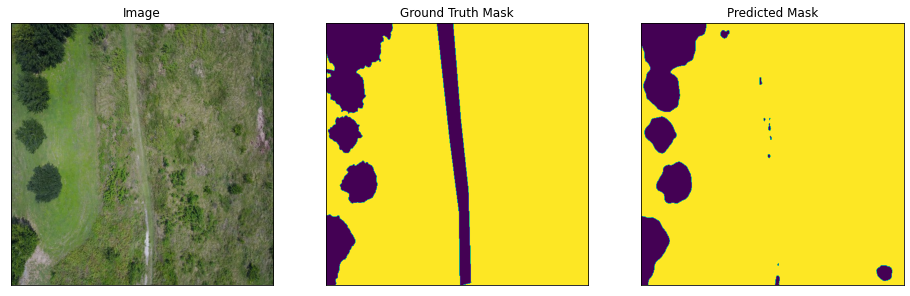

torch.Size([1, 3, 512, 512])


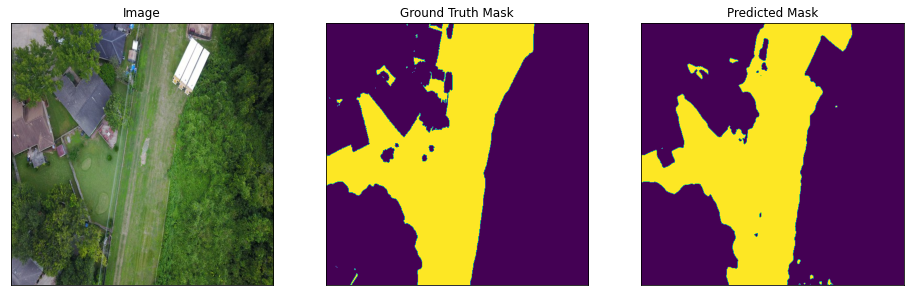

torch.Size([1, 3, 512, 512])


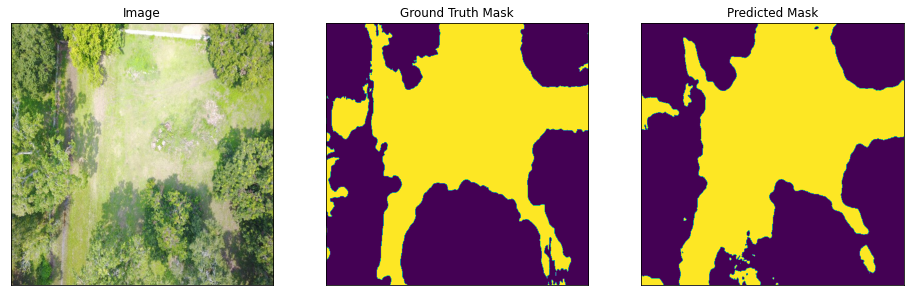

In [18]:
for i in range(3):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    print(x_tensor.shape)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
    
    
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask[9,:,:], 
        predicted_mask=pr_mask.squeeze()[9,:,:]
    )

In [19]:
model_cpu = best_model.to('cpu')

In [20]:
# time one prediction
%time
torch.no_grad()
image_vis = test_dataset_vis[i][0].astype('uint8')
image, gt_mask = test_dataset[i]

gt_mask = gt_mask.squeeze()

x_tensor = torch.from_numpy(image).unsqueeze(0)
pr_mask = model_cpu.predict(x_tensor)
pr_mask = pr_mask.squeeze().numpy().round()

Wall time: 0 ns


In [21]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

def animate(input_sample):
    num_frames = input_sample.shape[0]
    fig = plt.figure()
    plt.axis('off')
    im = plt.imshow(input_sample[0,:,:,:])

    def update(i):
        img = input_sample[i,:,:,:]
        im.set_data(img)
        return im

    ani = animation.FuncAnimation(fig, update, frames=num_frames, repeat=False, interval=60)  
    return ani

In [22]:
# # TODO find a way to get the frame rate of the video and calculate the required interval between frames
# # TODO scale up to full sized images
# vidcap = cv2.VideoCapture('video.MOV')
# frames_processed = []
# success, image_base = vidcap.read()
# val_aug = get_validation_augmentation()
# count = 0 

# while success:    
#     image_base = cv2.cvtColor(image_base, cv2.COLOR_BGR2RGB)
# #     image_base = cv2.rotate(image_base, cv2.ROTATE_90_CLOCKWISE)
    
#     image = cv2.resize(image_base, (512, 512))
#     frame = val_aug(image=image)['image']
#     frame = preprocessing_fn(frame)
#     frame = to_tensor(frame)
#     frame = torch.from_numpy(frame).unsqueeze(0)
#     pr_mask = model_cpu.predict(frame).squeeze().numpy() # .transpose(1,2,0)
    
#     pr_mask_full = cv2.resize(pr_mask[4], (image_base.shape[1], image_base.shape[0]))
#     pr_mask_full = np.expand_dims(pr_mask_full, 2)
    
#     pr_mask_full_2 = cv2.resize(pr_mask[9], (image_base.shape[1], image_base.shape[0]))
#     pr_mask_full_2 = np.expand_dims(pr_mask_full_2, 2)
    
#     pr_mask_full_3 = cv2.resize(pr_mask[5], (image_base.shape[1], image_base.shape[0]))
#     pr_mask_full_3 = np.expand_dims(pr_mask_full_3, 2)
    
#     pr_mask_full_4 = cv2.resize(pr_mask[2], (image_base.shape[1], image_base.shape[0]))
#     pr_mask_full_4 = np.expand_dims(pr_mask_full_4, 2)
    
#     pr_mask_full_5 = cv2.resize(pr_mask[6], (image_base.shape[1], image_base.shape[0]))
#     pr_mask_full_5 = np.expand_dims(pr_mask_full_5, 2)
    
    
#     transparency = 0.4
#     pr_mask_full *= transparency
    
#     transparency_2 = 0.4
#     pr_mask_full_2 *= transparency_2
    
#     transparency_3 = 0.4
#     pr_mask_full_3 *= transparency_3
    
#     transparency_4 = 0.4
#     pr_mask_full_4 *= transparency_4
    
#     transparency_5 = 0.4
#     pr_mask_full_5 *= transparency_5


#     # make a green overlay
#     blue  = np.ones(image_base.shape, dtype=np.float) * (10,10,0)
#     green = np.ones(image_base.shape, dtype=np.float) * (0,0,15)
#     red =  np.ones(image_base.shape, dtype=np.float) * (1,0,0)
#     pink =  np.ones(image_base.shape, dtype=np.float) * (10,0,10)
#     yellow =  np.ones(image_base.shape, dtype=np.float) * (0,10,0)
#     # green over original image
#     out = pink*pr_mask_full_5 +yellow*pr_mask_full_4 +red*pr_mask_full_3 + green*pr_mask_full_2 + blue*pr_mask_full + image_base*(1.0 - pr_mask_full) / 255
#     out = np.clip(out, 0, 1)
#     frames_processed.append(out)
#     count += 1
#     vidcap.set(1, count)
#     success, image_base = vidcap.read()
    
#     if count > 3000: break

In [23]:
# frames_processed = np.array(frames_processed)
# ani = animate(frames_processed)
# del frames_processed

In [24]:
# ani.save('road_mobilenetv2.gif')


In [25]:
# TODO find a way to get the frame rate of the video and calculate the required interval between frames
# TODO scale up to full sized images
vidcap = cv2.VideoCapture('video.MOV')
frames_processed = []
success, image_base = vidcap.read()
val_aug = get_validation_augmentation()
count = 0 

while success:    
    image_base = cv2.cvtColor(image_base, cv2.COLOR_BGR2RGB)
#     image_base = cv2.rotate(image_base, cv2.ROTATE_90_CLOCKWISE)
    
    image = cv2.resize(image_base, (512, 512))
    frame = val_aug(image=image)['image']
    frame = preprocessing_fn(frame)
    frame = to_tensor(frame)
    frame = torch.from_numpy(frame).unsqueeze(0)
    pr_mask = model_cpu.predict(frame).squeeze().numpy() # .transpose(1,2,0)
    pr_mask_full = cv2.resize(pr_mask[1], (image_base.shape[1], image_base.shape[0]))
    pr_mask_full = np.expand_dims(pr_mask_full, 2)
    
    
    transparency = 0.4
    pr_mask_full *= transparency
    

    # make a green overlay
    blue  = np.ones(image_base.shape, dtype=np.float) * (0,3,0)

    # green over original image
    out = blue*pr_mask_full + image_base*(1.0 - pr_mask_full) / 255
    out = np.clip(out, 0, 1)
    frames_processed.append(out)
    count += 1
    vidcap.set(1, count)
    success, image_base = vidcap.read()
    
    if count > 3000: break

In [26]:
# frames_processed = np.array(frames_processed)
# ani = animate(frames_processed)
# del frames_processed
# ani.save('road_org.gif')

In [27]:
# # TODO find a way to get the frame rate of the video and calculate the required interval between frames
# # TODO scale up to full sized images
# vidcap = cv2.VideoCapture('video.MOV')
# frames_processed = []
# success, image_base = vidcap.read()
# val_aug = get_validation_augmentation()
# count = 0 

# while success:    
#     image_base = cv2.cvtColor(image_base, cv2.COLOR_BGR2RGB)
# #     image_base = cv2.rotate(image_base, cv2.ROTATE_90_CLOCKWISE)
    
#     image = cv2.resize(image_base, (512, 512))
#     frame = val_aug(image=image)['image']
#     frame = preprocessing_fn(frame)
#     frame = to_tensor(frame)
#     frame = torch.from_numpy(frame).unsqueeze(0)
#     pr_mask = model_cpu.predict(frame).squeeze().numpy() # .transpose(1,2,0)
    
#     pr_mask_full_2 = cv2.resize(pr_mask[9], (image_base.shape[1], image_base.shape[0]))
#     pr_mask_full_2 = np.expand_dims(pr_mask_full_2, 2)
    
    
#     transparency_2 = 0.4
#     pr_mask_full_2 *= transparency_2
    

#     # make a green overlay
#     blue  = np.ones(image_base.shape, dtype=np.float) * (0,10,0)
#     green = np.ones(image_base.shape, dtype=np.float) * (0,0,10)
#     red =  np.ones(image_base.shape, dtype=np.float) * (1,0,0)

#     # green over original image
#     out = green*pr_mask_full_2 + image_base*(1.0 - pr_mask_full) / 255
#     out = np.clip(out, 0, 1)
#     frames_processed.append(out)
#     count += 2
#     vidcap.set(1, count)
#     success, image_base = vidcap.read()
    
#     if count > 680: break

In [28]:
# frames_processed = np.array(frames_processed)
# ani = animate(frames_processed)
# del frames_processed
# ani.save('video_three.gif')

In [29]:
# TODO find a way to get the frame rate of the video and calculate the required interval between frames
# TODO scale up to full sized images
# vidcap = cv2.VideoCapture('building.MOV')
# frames_processed = []
# success, image_base = vidcap.read()
# val_aug = get_validation_augmentation()
# count = 0 

# while success:    
#     image_base = cv2.cvtColor(image_base, cv2.COLOR_BGR2RGB)
# #     image_base = cv2.rotate(image_base, cv2.ROTATE_90_CLOCKWISE)
    
#     image = cv2.resize(image_base, (512, 512))
#     frame = val_aug(image=image)['image']
#     frame = preprocessing_fn(frame)
#     frame = to_tensor(frame)
#     frame = torch.from_numpy(frame).unsqueeze(0)
#     pr_mask = model_cpu.predict(frame).squeeze().numpy() # .transpose(1,2,0)
    
#     pr_mask_full_3 = cv2.resize(pr_mask[7], (image_base.shape[1], image_base.shape[0]))
#     pr_mask_full_3 = np.expand_dims(pr_mask_full_3, 2)
    
#     transparency_3 = 0.4
#     pr_mask_full_3 *= transparency_3

#     # make a green overlay
#     blue  = np.ones(image_base.shape, dtype=np.float) * (0,10,0)
#     green = np.ones(image_base.shape, dtype=np.float) * (0,0,10)
#     red =  np.ones(image_base.shape, dtype=np.float) * (10,10,0)

#     # green over original image
#     out = red*pr_mask_full_3 + image_base*(1.0 - pr_mask_full_3) / 255
#     out = np.clip(out, 0, 1)
#     frames_processed.append(out)
#     count += 2
#     vidcap.set(1, count)
#     success, image_base = vidcap.read()
    
#     if count > 1600: break

In [30]:
# frames_processed = np.array(frames_processed)
# ani = animate(frames_processed)
# del frames_processed
# ani.save('video_five.gif')

In [31]:
import time
vidcap = cv2.VideoCapture('building.MOV')
frames_processed = []
success, image_base = vidcap.read()
val_aug = get_validation_augmentation()
count = 0 

frame_count = 0 # to count total frames
total_fps = 0 # to get the final frames per second
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(device)
model_cpu.to(device); 

while success:    
    image_base = cv2.cvtColor(image_base, cv2.COLOR_BGR2RGB)
#     image_base = cv2.rotate(image_base, cv2.ROTATE_90_CLOCKWISE)
    
    image = cv2.resize(image_base, (512, 512))
    
    x_tensor = torch.from_numpy(image).to(device).unsqueeze(0)
    
    x_tensor = x_tensor.view(1,3, 512, 512)
    x_tensor = x_tensor.float()
    start_time = time.time()
    pr_mask = best_model.predict(x_tensor)
    end_time = time.time()
    
    # get the fps
    fps = 1.0 /(end_time - start_time)
    # add fps to total fps
    total_fps += fps
    # increment frame count
    frame_count += 1

    count += 1
    vidcap.set(1, count)
    success, image_base = vidcap.read()
    
    if count > 10: break

In [32]:
# calculate and print the average FPS
avg_fps = total_fps / frame_count
print(f"Average FPS: {avg_fps:.3f}")

Average FPS: 31.732


In [33]:
!pip install ptflops

In [34]:
import torchvision.models as models
import torch
from ptflops import get_model_complexity_info

with torch.cuda.device(0):
    net = model_cpu
    macs, params = get_model_complexity_info(net, (3, 512, 512), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
    print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
    print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Unet(
  3.315 M, 7.564% Params, 12.197 GMac, 100.000% MACs, 
  (encoder): EfficientNetEncoder(
    0.224 M, 0.512% Params, 0.311 GMac, 2.553% MACs, 
    (_conv_stem): Conv2dStaticSamePadding(
      0.0 M, 0.000% Params, 0.0 GMac, 0.000% MACs, 3, 56, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d(0.0 M, 0.000% Params, 0.0 GMac, 0.000% MACs, padding=(0, 1, 0, 1), value=0.0)
    )
    (_bn0): BatchNorm2d(0.0 M, 0.000% Params, 0.007 GMac, 0.060% MACs, 56, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      0.22 M, 0.501% Params, 0.304 GMac, 2.493% MACs, 
      (0): MBConvBlock(
        0.0 M, 0.000% Params, 0.012 GMac, 0.095% MACs, 
        (_depthwise_conv): Conv2dStaticSamePadding(
          0.0 M, 0.000% Params, 0.0 GMac, 0.000% MACs, 56, 56, kernel_size=(3, 3), stride=[1, 1], groups=56, bias=False
          (static_padding): ZeroPad2d(0.0 M, 0.000% Params, 0.0 GMac, 0.000% MACs, padding=(1, 1

In [35]:
model = model_cpu
device = torch.device("cuda")
model.to(device)
dummy_input = torch.randn(1, 3,512,512, dtype=torch.float).to(device)
# INIT LOGGERS
starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
repetitions = 300
timings=np.zeros((repetitions,1))
#GPU-WARM-UP
for _ in range(10):
    _ = model(dummy_input)
# MEASURE PERFORMANCE
with torch.no_grad():
    for rep in range(repetitions):
        starter.record()
        _ = model(dummy_input)
        ender.record()
        # WAIT FOR GPU SYNC
        torch.cuda.synchronize()
        curr_time = starter.elapsed_time(ender)
        timings[rep] = curr_time
mean_syn = np.sum(timings) / repetitions
std_syn = np.std(timings)
print(mean_syn)

30.71515059153239
